# Forecast stock market shares

Author: PhD. [Wesley Lima](https://github.com/WesleyJw)

Code tested on:

- Tensorflow: 2.2.0
- Keras: 2.4.3

This is a basic project to forecast the stock price (Day's open) for General Eletric Company (GE) and Petrobras. To forecast day's open price we considering the closing price, intraday high, intraday low and volume as input variables.  This data is a time serie available from [Finance yahoo](https://finance.yahoo.com/quote/GE/history/).

## 1. Data Science Questions

### 1.1 What is the problem? 

I want to invest some money in the shares of the general electric and Petrobras companies and I want to be more precise at the right time to invest.

### 1.2 What's the ideal solution?

Know the next day stock open price, using fourteen days before and closing price, intraday high, intraday low and volume as input variables.  

### 1.3 How can I do this with Data Science and/or Machine Learning? 

Create a model to forecast the next day stock open price.

### 1.4 How will this solution be used in production? 

This solution will be used from a web app that the user can input day and the another variables and give a graph with time series trend and open price value estimated. 

### 1.5 How will I know it worked?

The precision of the model will be calculated by root mean square error and residual analysis. 

## 2. Business questions

- 1. Is there a significant trend in the increase in days's open stock price?

- 2. Is there a significant seasonal effect on days's open stock price?

- 3. Is it possible to build a model to predict next days's open stock price?

## 3. LSTM Model Fit

In [48]:
## Libs
import numpy as np
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

### 3.1 Model Fit to General Eletric Company

In [10]:
# Get General eletric company Data
data_ge = pd.read_csv("../datasets/GE.csv")
print("\n", 5*">", "Data shape: \n", data_ge.shape)
print("\n", 5*">", "Data Info: \n")
data_ge.info()
print("\n", 5*">", "Head Data: \n")
data_ge.head()


 >>>>> Data shape: 
 (5738, 7)

 >>>>> Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5738 entries, 0 to 5737
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5738 non-null   object 
 1   Open       5738 non-null   float64
 2   High       5738 non-null   float64
 3   Low        5738 non-null   float64
 4   Close      5738 non-null   float64
 5   Adj Close  5738 non-null   float64
 6   Volume     5738 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 313.9+ KB

 >>>>> Head Data: 



,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,377.564117,379.487183,369.230774,369.230774,203.009735,2875782
1,2000-01-05,368.589752,376.923065,365.544861,368.589752,202.657303,3548064
2,2000-01-06,366.987183,376.762817,365.705139,373.517639,205.366714,2583516
3,2000-01-07,379.487183,389.423065,376.923065,387.980774,213.318863,2618382
4,2000-01-10,391.506409,395.032043,387.500000,387.820526,213.230606,1979445


In [13]:
# Get dates for future plots
train_dates = pd.to_datetime(data_ge["Date"])

In [16]:
# Variables sfor training
cols = list(data_ge)[1:7]
print("\n", 5*">", "Cols used to train: \n", cols)


 >>>>> Cols used to train: 
 ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [17]:
# transform to float
df_for_training = data_ge[cols].astype(float)

In [21]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [46]:
# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

# Number of days we want to look into the future based on the past days.
n_future = 1
n_past = 14  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
# In my example, my df_for_training_scaled has a shape (12823, 5)
# 12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(
        df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (5724, 14, 6).
trainY shape == (5724, 1).


In [49]:
# In my case, trainX has a shape (12809, 14, 5).
# 12809 because we are looking back 14 days (12823 - 14 = 12809).
# Remember that we cannot look back 14 days until we get to the 15th day.
# Also, trainY has a shape (12809, 1). Our model only predicts a single value, but
# it needs multiple variables (5 in my example) to make this prediction.
# This is why we can only predict a single day after our training, the day after where our data ends.
# To predict more days in future, we need all the 5 variables which we do not have.
# We need to predict all variables if we want to do that.

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(
    trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2022-10-23 06:49:25.521247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-23 06:49:25.557274: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-23 06:49:25.573955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wesley-ds): /proc/driver/nvidia/version does not exist
2022-10-23 06:49:26.005392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [50]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16,
                    validation_split=0.1, verbose=1)

Epoch 1/5
322/322 [==============================] - 17s 23ms/step - loss: 0.0845 - val_loss: 0.0095
Epoch 2/5
322/322 [==============================] - 8s 24ms/step - loss: 0.0286 - val_loss: 0.0077
Epoch 3/5
322/322 [==============================] - 15s 46ms/step - loss: 0.0259 - val_loss: 0.0034
Epoch 4/5
322/322 [==============================] - 20s 62ms/step - loss: 0.0239 - val_loss: 0.0031
Epoch 5/5
322/322 [==============================] - 19s 58ms/step - loss: 0.0254 - val_loss: 0.0025


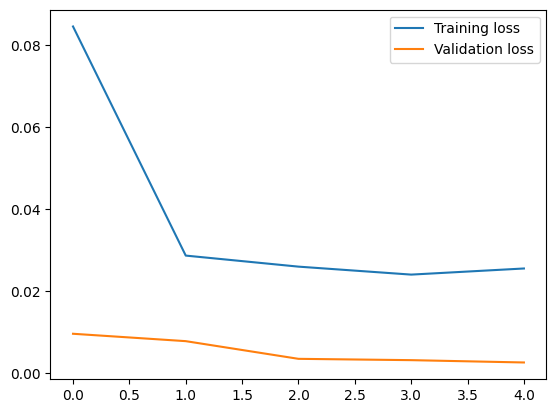

In [51]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [52]:
# Predicting...
# Libraries that will help us extract only business days in the US.
# Otherwise our dates would be wrong when we look back (or forward).
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
# Remember that we can only predict one day in future as our model needs 5 variables
# as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction = 15  # let us predict past 15 days

predict_period_dates = pd.date_range(
    list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2022-09-30 00:00:00', freq='C'), Timestamp('2022-10-03 00:00:00', freq='C'), Timestamp('2022-10-04 00:00:00', freq='C'), Timestamp('2022-10-05 00:00:00', freq='C'), Timestamp('2022-10-06 00:00:00', freq='C'), Timestamp('2022-10-07 00:00:00', freq='C'), Timestamp('2022-10-11 00:00:00', freq='C'), Timestamp('2022-10-12 00:00:00', freq='C'), Timestamp('2022-10-13 00:00:00', freq='C'), Timestamp('2022-10-14 00:00:00', freq='C'), Timestamp('2022-10-17 00:00:00', freq='C'), Timestamp('2022-10-18 00:00:00', freq='C'), Timestamp('2022-10-19 00:00:00', freq='C'), Timestamp('2022-10-20 00:00:00', freq='C'), Timestamp('2022-10-21 00:00:00', freq='C')]


In [54]:
# Make prediction
# shape = (n, 1) where n is the n_days_for_prediction
prediction = model.predict(trainX[-n_days_for_prediction:])

1/1 [==============================] - 1s 510ms/step


In [55]:
# Perform inverse transformation to rescale back to original range
# Since we used 5 variables for transform, the inverse expects same dimensions
# Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

In [57]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame(
    {'Date': np.array(forecast_dates), 'Open': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])


original = data_ge[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

/tmp/ipykernel_28634/3972565512.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


<AxesSubplot: xlabel='Date', ylabel='Open'>

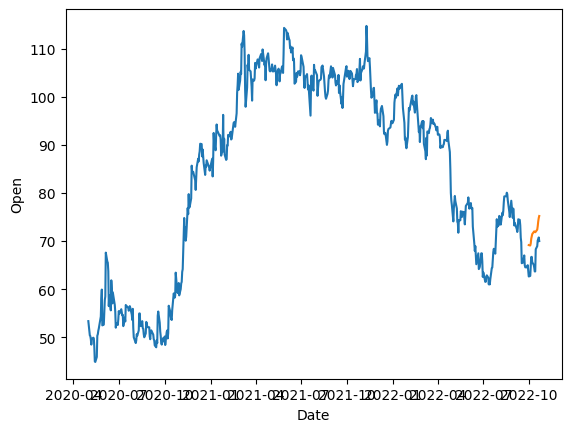

In [59]:
sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])

In [12]:
# Get Petrobras stcok data
data_br = pd.read_csv("../datasets/PETR4_SA.csv")
print("\n", 5*">", "Data shape: \n", data_br.shape)
print("\n", 5*">", "Data Info: \n")
data_br.info()
print("\n", 5*">", "Head Data: \n")
data_br.head()


 >>>>> Data shape: 
 (5731, 7)

 >>>>> Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5731 entries, 0 to 5730
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5731 non-null   object 
 1   Open       5730 non-null   float64
 2   High       5730 non-null   float64
 3   Low        5730 non-null   float64
 4   Close      5730 non-null   float64
 5   Adj Close  5730 non-null   float64
 6   Volume     5730 non-null   float64
dtypes: float64(6), object(1)
memory usage: 313.5+ KB

 >>>>> Head Data: 



,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,5.550,5.550,5.550,5.550,2.021227,2.886144e+10
1,2000-01-05,5.494,5.494,5.494,5.494,2.000833,4.303360e+10
2,2000-01-06,5.475,5.475,5.475,5.475,1.993914,3.405568e+10
3,2000-01-07,5.500,5.500,5.500,5.500,2.003018,2.091264e+10
4,2000-01-10,5.613,5.613,5.613,5.613,2.044171,1.956352e+10
